In [1]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis

from CICIDS2017.dataset import CICIDS2017
from CICIDS2017.analysis.features import recompute_features

from scripts.models.pytorch.MLP import NetworkIntrusionMLP

from scripts.models.pytorch.train import train
from scripts.models.pytorch.visualization import display_loss

from NIDS_attacks.fgsm import attack_fgsm
from NIDS_attacks.bounds_constrains import apply_bounds_constraints
from NIDS_attacks.integers_constrains import apply_integer_constraints

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lm = LoggerManager(
    root_dir=root_dir,
    log_name="ADV_ATT_FGSM_MLP_CICIDS2017",
)
logger = lm.get_logger()
title = lm.get_title()
logger.info(f"Logger initialized for '{title}'")
logger.info(f"Using device: {device}")

2025-11-27 09:39:03,341 - INFO - Logger initialized for 'ADV_ATT_FGSM_MLP_CICIDS2017_20251127_093903'
2025-11-27 09:39:03,343 - INFO - Using device: cuda:0


In [2]:
full_dataset = CICIDS2017( # [UNSWNB15() or CICIDS2017()]
    dataset_size="small",
    logger=logger
).optimize_memory().encode(attack_encoder="label")

dataset = full_dataset.subset(size=900*1000, multi_class=True)

X_train, X_val, y_train, y_val = dataset.split(
    one_hot=True,
    apply_smote=False,
    to_tensor=True
)

# Create DataLoaders
train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
val_dataset = TensorDataset(X_val.to(device), y_val.to(device))

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

2025-11-27 09:39:03,349 - INFO - Downloading dataset: sweety18/cicids2017-full-dataset
2025-11-27 09:39:04,027 - INFO - Loading dataset into DataFrame
2025-11-27 09:39:17,809 - INFO - Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
2025-11-27 09:39:33,307 - INFO - Removed 1,147 rows with non-positive 'Flow Duration'. Remaining: 1,941,546
2025-11-27 09:39:34,145 - INFO - ============================================================
2025-11-27 09:39:34,145 - INFO - Preprocessing completed successfully
2025-11-27 09:39:34,146 - INFO - Final dimensions: 1,939,551 rows x 71 columns
2025-11-27 09:39:34,146 - INFO - Total rows removed: 274,918 (12.41%)
2025-11-27 09:39:34,147 - INFO - data retention rate: 87.59%
2025-11-27 09:39:34,147 - INFO - ============================================================
2025-11-27 09:39:34,148 - INFO - Optimizing memory usage of the dataset...
2025-11-27 09:39:34,151 - INFO - Initial memory usage: 1065.43 MB
2025-11-27 09:39:34,799 - INFO 

In [3]:
input_size = train_loader.dataset.tensors[0].shape[1]
num_classes = train_loader.dataset.tensors[1].shape[1]
print(f"Input Size: {input_size}, Num Classes: {num_classes}")

model_mlp = NetworkIntrusionMLP(
    input_size=input_size,
    layer_features=[128, 64, 32],
    layer_classifier=[16],
    num_classes=num_classes,
    device=device
)
model_mlp = model_mlp.load_model(f"{root_dir}/NIDS_attacks/pretrained_models/MLP{input_size}x{num_classes}.400.pt")

Input Size: 70, Num Classes: 4


2025-11-27 09:39:39,943 - INFO - Running analysis for PyTorch model: MLP - CICIDS2017 - Before Attack on device: cuda:0


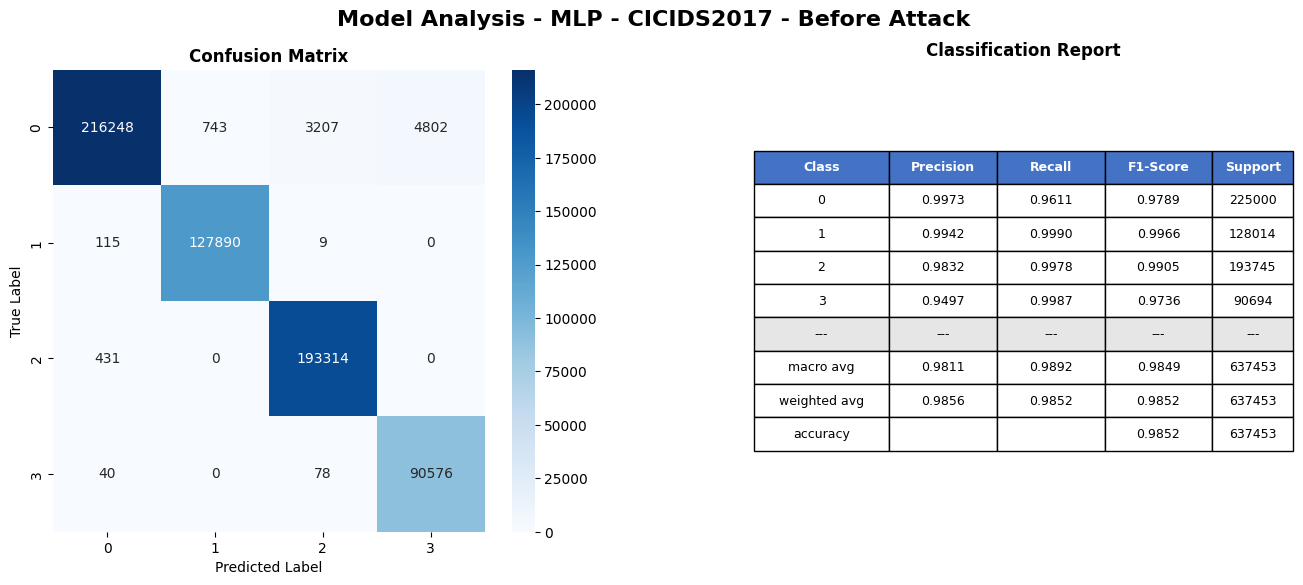

In [4]:
cm, cr = perform_model_analysis(
    model=model_mlp,
    X_test=torch.vstack((X_train, X_val)),
    y_test=torch.vstack((y_train, y_val)),
    logger=logger,
    root_dir=root_dir,
    title="MLP - CICIDS2017 - Before Attack",
    plot=True,
    device=device
)

In [5]:
# Let's define our adversarial input: 
# it is a copy of our original input, and we will need to be able to compute the gradient with respect to that input

attack_indices = dataset.is_attack[dataset.is_attack == 1].index.tolist()
random_idx = torch.randperm(len(attack_indices))[:20]

adversarial_attack_input = dataset.features.iloc[attack_indices].iloc[random_idx].values.astype('float32')

# To Tensor
adversarial_attack_input = torch.FloatTensor(adversarial_attack_input).to(device)

print("Original input:", adversarial_attack_input.shape)

Original input: torch.Size([20, 70])


In [6]:
x_adv = adversarial_attack_input.clone().detach().requires_grad_(True)
criterion = nn.CrossEntropyLoss()

# Targeting the 'benign' class
target = torch.LongTensor([0]).repeat(x_adv.shape[0]).to(device)

print("Target class for the attack:", target.shape)

model_mlp.eval()
epsilon = 1

# Initial prediction
initial_x_adv, initial_loss, initial_pred = attack_fgsm(
    model=model_mlp,
    criterion=criterion,
    x_val=x_adv,
    target=target,
    eps=0.0
)

print("Initial prediction on adversarial input:", initial_pred.argmax(axis=1))

list_x_adv = [initial_x_adv]
for iter in range(100):
    new_x_adv, loss, pred = attack_fgsm(
        model=model_mlp,
        criterion=criterion,
        x_val=x_adv,
        target=target,
        eps=epsilon
    )

    # Recompute derived features
    x_adv_rf = recompute_features(new_x_adv)

    # Apply bounds constraints
    x_adv = apply_bounds_constraints(
        x_adv=new_x_adv,
        x_original=x_adv_rf,
        modifiable_indices=dataset.MODIFIABLE_FEATURES,
        min_vals=X_train.min(axis=0).values.to(device),
        max_vals=X_train.max(axis=0).values.to(device)
    )

    # Check if attack is successful
    if pred.argmax(axis=1).sum() == 0:
        x_adv = apply_integer_constraints(
            x_adv=new_x_adv,
            integer_indices=dataset.INTEGER_INDICES
        )

        # Final evaluation without perturbation
        x_adv, loss, pred = attack_fgsm(
            model=model_mlp,
            criterion=criterion,
            x_val=x_adv,
            target=target,
            eps=0.0
        )

        # Check if attack is successful after applying constraints
        if pred.argmax(axis=1).sum() == 0:
            print(f"Successful adversarial example found at iteration {iter+1}")
            break


print(f"Adversarial input after {iter+1} iterations:", pred.argmax(axis=1))
diff_adv = x_adv - initial_x_adv
print("Magnitude of perturbation:")
print("Mean:", torch.norm(diff_adv, dim=1).cpu().numpy().mean())
print("Min:", torch.norm(diff_adv, dim=1).cpu().numpy().min())
print("Max:", torch.norm(diff_adv, dim=1).cpu().numpy().max())
print("Std:", torch.norm(diff_adv, dim=1).cpu().numpy().std())

Target class for the attack: torch.Size([20])
Initial prediction on adversarial input: [2 1 1 2 2 1 3 2 2 2 1 2 2 2 2 1 1 2 3 1]
Successful adversarial example found at iteration 6
Adversarial input after 6 iterations: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Magnitude of perturbation:
Mean: 6.2644305e+06
Min: 3085.3384
Max: 8.33e+07
Std: 1.8162488e+07


In [7]:
results_df = pd.DataFrame(
    data=(torch.vstack((
        *initial_x_adv,
        *diff_adv,
        *x_adv,
        X_train.min(axis=0).values.to(device),
        X_train.max(axis=0).values.to(device)
    )).cpu().numpy()),
    columns=dataset.features.columns,
)

results_df.style

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,80.000000,9318.000000,2.000000,1.000000,12.000000,0.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1287.829956,321.957489,4659.000000,6378.103027,9169.000000,149.000000,9318.000000,9318.000000,0.000000,9318.000000,9318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,32.000000,214.638336,107.319168,0.000000,6.000000,4.500000,3.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,6.000000,0.000000,40.000000,2.000000,12.000000,1.000000,0.000000,0.000000,235.000000,1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,80.000000,1319149.000000,3.000000,7.000000,26.000000,11607.000000,20.000000,0.000000,8.666667,10.263203,4380.000000,0.000000,1658.142822,1762.272827,8818.564453,7.580645,146572.109375,439263.750000,1317942.000000,2.000000,908.000000,454.000000,503.460022,810.000000,98.000000,1319038.000000,219839.671875,537958.187500,1317942.000000,2.000000,0.000000,0.000000,72.000000,152.000000,2.274194,5.306451,0.000000,4380.000000,1057.545410,1599.303223,2557770.750000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1163.300049,8.666667,1658.142822,72.000000,3.000000,26.000000,7.000000,11607.000000,8192.000000,229.000000,2.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,80.000000,4167898.000000,4.000000,0.000000,24.000000,0.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.758298,0.959716,1389299.375000,2405516.000000,4166950.000000,1.000000,4167898.000000,1389299.375000,2405516.000000,4166950.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000,0.000000,0.959716,0.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,7.500000,6.000000,0.000000,80.000000,4.000000,24.000000,0.000000,0.000000,256.000000,-1.000000,3.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,80.000000,99132320.000000,7.000000,6.000000,288.000000,11595.000000,288.000000,0.000000,41.142857,108.853767,5792.000000,0.000000,1932.500000,2362.781494,119.870094,0.131138,8261026.500000,28600000.000000,99100000.000000,1.000000,99100000.000000,16500000.000000,40500000.000000,99100000.000000,1.000000,12059.000000,2411.800049,4847.927734,11079.000000,64.000000,0.000000,0.000000,232.000000,200.000000,0.070613,0.060525,0.000000,5792.000000,848.785706,1761.071411,3101372.250000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,914.076904,41.142857,1932.500000,232.000000,7.000000,288.000000,6.000000,11595.000000,251.000000,235.000000,1.000000,32.000000,996.000000,0.000000,996.000000,996.000000,9